## Medial Axis


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid
from skimage.morphology import medial_axis
from skimage.util import invert
#from planning import a_star
%matplotlib inline 

In [2]:
plt.rcParams['figure.figsize'] = 12, 12

In [3]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ..., 
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


Starting and goal positions in *(north, east)*.

In [4]:
start_ne = (25,  100)
goal_ne = (650, 500)

In [5]:
# Static drone altitude (meters)
drone_altitude = 5
safety_distance = 2

In [6]:
grid = create_grid(data, drone_altitude, safety_distance)
#print(grid.shape)
skeleton = medial_axis(invert(grid))
#print(skeleton.shape)


Plot the edges on top of the grid along with start and goal locations.

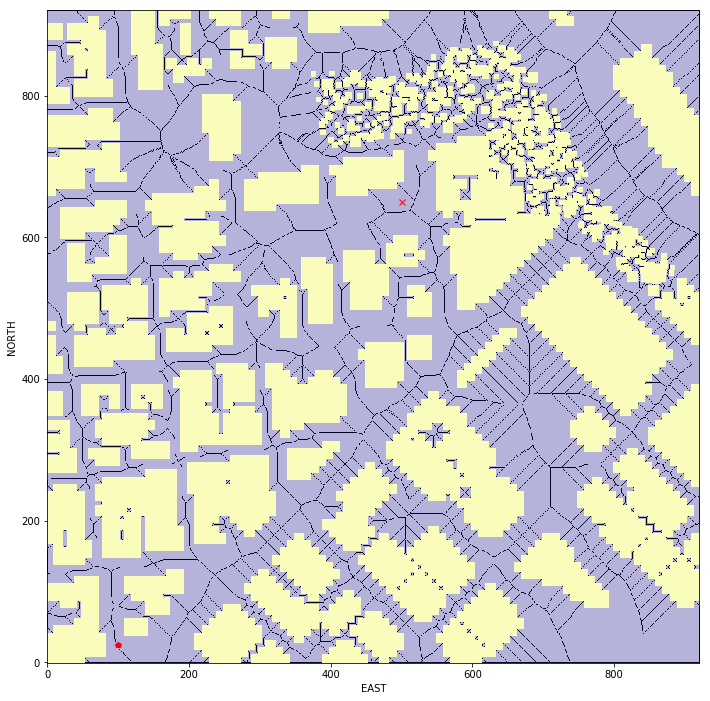

In [7]:
# equivalent to
# plt.imshow(np.flip(grid, 0))

plt.imshow(grid, cmap='plasma', origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
    
plt.plot(start_ne[1], start_ne[0], 'rp')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [8]:
# TODO: Your start and goal location defined above
# will not necessarily be on the skeleton so you
# must first identify the nearest cell on the 
# skeleton to start and goal

def find_start_goal(skel, start, goal):
    # TODO: find start and goal on skeleton
    # Some useful functions might be:
        # np.nonzero()
        # np.transpose()
        # np.linalg.norm()
        # np.argmin()
    skel_points = np.transpose(skel.nonzero())
    start_addr = np.linalg.norm(np.array(start) - skel_points,
                               axis = 1).argmin()
    near_start = skel_points[start_addr]
    goal_addr = np.linalg.norm(np.array(goal) - skel_points,
                              axis = 1).argmin()
    near_goal = skel_points[goal_addr]
    return near_start, near_goal

skel_start, skel_goal = find_start_goal(skeleton, start_ne, goal_ne)

print(start_ne, goal_ne)
print(skel_start, skel_goal)


(25, 100) (650, 500)
[24 99] [636 501]


In [27]:
def heuristic_func(position, goal_position):
    # TODO: define a heuristic
    h = abs(position[0] - goal_position[0]) + abs(position[1] - goal_position[1])
    return h

def eucl_heuristic(position, goal_position):
    h2 = np.sqrt((position[0] - goal_position[0])**2 + (position[1] - goal_position[1])**2)
    return h2

from enum import Enum
from queue import PriorityQueue

class Action(Enum):
    """
    An action is represented by a 3 element tuple.
    
    The first 2 values are the delta of the action relative
    to the current grid position. The third and final value
    is the cost of performing the action.
    """
    WEST = (0, -1, 1)
    EAST = (0, 1, 1)
    NORTH = (-1, 0, 1)
    SOUTH = (1, 0, 1)
    NORTH_WEST = (-1, -1, np.sqrt(2))
    NORTH_EAST = (-1, 1, np.sqrt(2))
    SOUTH_WEST = (1, -1, np.sqrt(2))
    SOUTH_EAST = (1, 1, np.sqrt(2))
    
    def __str__(self):
        if self == self.LEFT:
            return '<'
        elif self == self.RIGHT:
            return '>'
        elif self == self.UP:
            return '^'
        elif self == self.DOWN:
            return 'v'
    
    @property
    def cost(self):
        return self.value[2]
    
    @property
    def delta(self):
        return (self.value[0], self.value[1])
            
    
def valid_actions(grid, current_node):
    """
    Returns a list of valid actions given a grid and current node.
    """
    valid = list(Action)
    n, m = grid.shape[0] - 1, grid.shape[1] - 1
    x, y = current_node
    
    # check if the node is off the grid or
    # it's an obstacle
    
    if x - 1 < 0 or grid[x-1, y] == 1:
        valid.remove(Action.NORTH)
    if x + 1 > n or grid[x+1, y] == 1:
        valid.remove(Action.SOUTH)
    if y - 1 < 0 or grid[x, y-1] == 1:
        valid.remove(Action.WEST)
    if y + 1 > m or grid[x, y+1] == 1:
        valid.remove(Action.EAST)
        
    if (x - 1 < 0 or y - 1 < 0) or grid[x-1,y-1] == 1:
        valid.remove(Action.NORTH_WEST)
    if (x - 1 < 0 or y + 1 > m) or grid[x-1,y+1] == 1:
        valid.remove(Action.NORTH_EAST)
    if (x + 1 > n or y - 1 < 0) or grid[x+1,y-1] == 1:
        valid.remove(Action.SOUTH_WEST)
    if (x + 1 > n or y + 1 > m) or grid[x+1,y+1] == 1:
        valid.remove(Action.SOUTH_EAST)
        
    return valid

def a_star(grid, h, start, goal):

    path = []
    queue = PriorityQueue()
    path_cost = 0
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for action in valid_actions(grid, current_node):
                # get the tuple representation
                da = action.delta
                next_node = (current_node[0] + da[0], current_node[1] + da[1])
                # TODO: calculate new cost, c + g() + h()
                branch_cost = current_cost + action.cost
                new_cost = branch_cost + h(next_node, goal)
#                print(h(next_node,goal))
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (branch_cost, current_node, action)
             
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
            
    return path[::-1], path_cost


### TODO: Run A* on the skeleton
see [planning.py](/edit/planning.py) for a reminder on how to run the imported A* implementation (or rewrite it!)

In [28]:
#Manhattan heuristic
#print(invert(skeleton).astype(np.int))
path, cost = a_star(invert(skeleton).astype(np.int), heuristic_func,
                    tuple(skel_start), tuple(skel_goal))
#print(path[0:5])
print("path = {0}, cost = {1}".format(len(path),cost))
# Compare to regular A* on the grid
path2, cost2 = a_star(grid, heuristic_func, start_ne, goal_ne)
#print(type(path))
print("path_gr = {0}, cost_gr = {1}".format(len(path2),cost2))

#Euclidian Heuristic
#print(invert(skeleton).astype(np.int))
path3, cost3 = a_star(invert(skeleton).astype(np.int), eucl_heuristic,
                    tuple(skel_start), tuple(skel_goal))
print("Euc path = {0}, cost = {1}".format(len(path),cost))
# Compare to regular A* on the grid
path4, cost4 = a_star(grid, eucl_heuristic, start_ne, goal_ne)
#print(type(path))
print("Euc path_gr = {0}, cost_gr = {1}".format(len(path2),cost2))

Found a path.
path = 826, cost = 1004.1118318204353
Found a path.
path_gr = 665, cost_gr = 843.940258945181
Found a path.
Euc path = 826, cost = 1004.1118318204353
Found a path.
Euc path_gr = 665, cost_gr = 843.940258945181


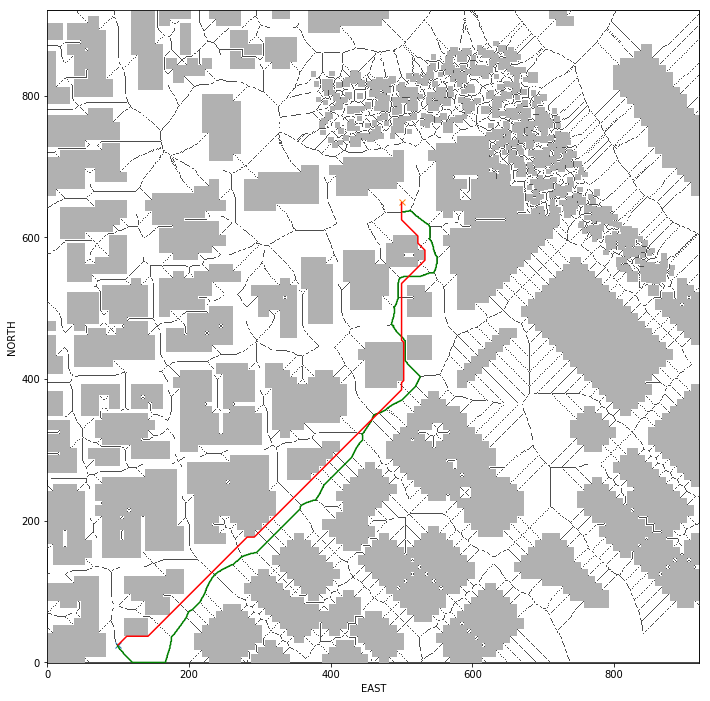

In [20]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
# Uncomment the following as needed
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(path)
#print(pp.shape)
plt.plot(pp[:, 1], pp[:, 0], 'g')
pp2 = np.array(path2)
plt.plot(pp2[:, 1], pp2[:, 0], 'r')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

[solution](/notebooks/Medial-Axis-Solution.ipynb)